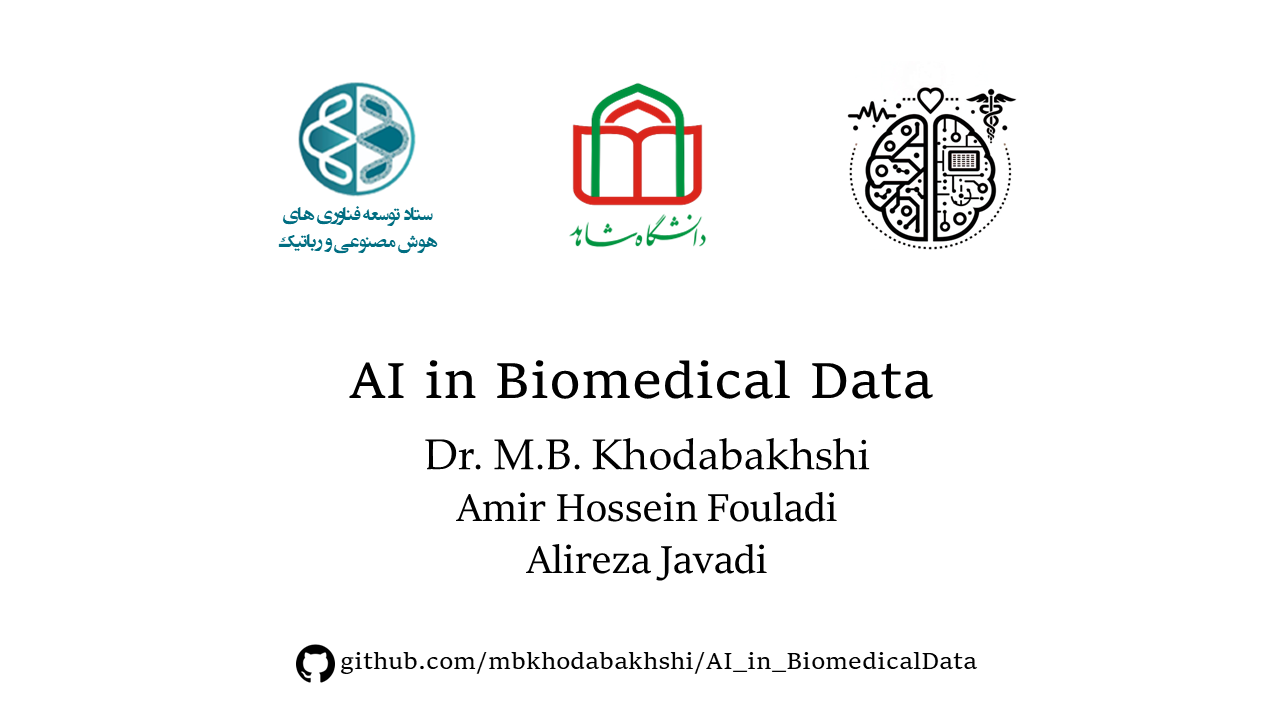

https://github.com/mbkhodabakhshi/AI_in_BiomedicalData

----------------

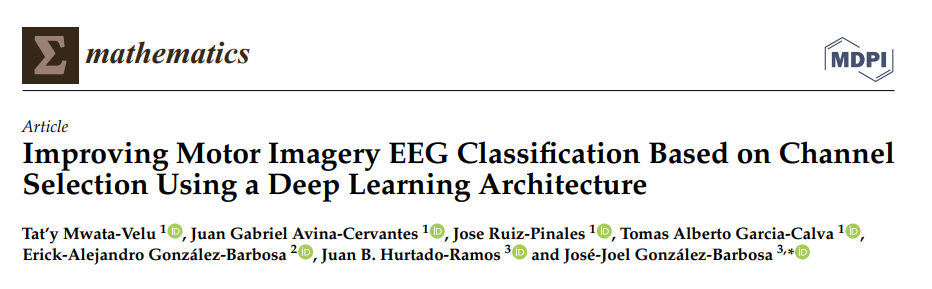

https://doi.org/10.3390/math10132302

-------------------------

# Dataset

https://doi.org/10.1038/sdata.2018.211

-------------------------------------------

# Preprocessing

## load data

First, download the data related to the 5F paradigm of subject A with low-frequency. Then, appropriately convert the data and labels into tensors.

In [1]:
import os
import scipy.io
import numpy as np
import torch

fr_samp= 200
path= r'./data/'
file_list= os.listdir(path)

data= torch.tensor([])
mark= torch.tensor([])
data_list= []
marker_list= []
for file_name in file_list:
    if file_name.endswith('.mat'):
        file_path= os.path.join(path, file_name)
        mat_data= scipy.io.loadmat(file_path)
        data_array= np.array(mat_data['o']['data'][0, 0])
        marker_array= np.array(mat_data['o']['marker'][0, 0])
        torch_data= torch.from_numpy(data_array)
        torch_marker= torch.from_numpy(marker_array)
        data= torch.cat((data, torch_data), dim=0)
        mark= torch.cat((mark, torch_marker), dim=0)
        
mark= mark[:,0]
print(mark.shape)
print(data.shape)

torch.Size([718600])
torch.Size([718600, 22])


## finding the first sample of each trial

To separate the trials of the motor imagery task, identify the first sample of each trial and store each task in separate parameters.

In [2]:
pr= 0
cl_1_ind= []
cl_2_ind= []
cl_3_ind= []
cl_4_ind= []
cl_5_ind= []

for i in range(mark.shape[0]):
    nx= mark[i]
    if pr != nx:
        if nx== 1:
            cl_1_ind.append(i)
        elif nx== 2:
            cl_2_ind.append(i)
        elif nx== 3:
            cl_3_ind.append(i)
        elif nx== 4:
            cl_4_ind.append(i)
        elif nx== 5:
            cl_5_ind.append(i)
    pr= nx
        
print(len(cl_1_ind), len(cl_2_ind), len(cl_3_ind), len(cl_4_ind), len(cl_5_ind))

209 172 198 191 189


## separation of trials

Obtain the trials related to the three motor imagery tasks: thumb, middle finger, and pinkie finger, considering each trial to be one second long.

In [3]:
def trial_sepration(data, mark_indx, length= 200):
    output= torch.tensor([])
    for index in mark_indx:
        output= torch.cat((output, data[index: index+length, :].unsqueeze(0)), dim= 0)
    return output

In [4]:
def data_mark_maker(cl_ind, new_mark, dataset= data):
    cls_data= trial_sepration(dataset, cl_ind)
    cls_mark= torch.full((cls_data.shape), new_mark, dtype=torch.long)[:,0,0]
    return cls_data, cls_mark

In [5]:
cls_1_data, cls_1_mark= data_mark_maker(cl_1_ind, 0)
cls_3_data, cls_3_mark= data_mark_maker(cl_3_ind, 1)
cls_5_data, cls_5_mark= data_mark_maker(cl_5_ind, 2)

In [6]:
del cl_1_ind, cl_2_ind, cl_3_ind, cl_4_ind, cl_5_ind

## concat cls

Concatenate the trials of all three classes together and shuffle them. Ensure that the data and labels are in the appropriate format.

In [7]:
data= torch.cat((cls_1_data, cls_3_data, cls_5_data), dim= 0)
mark= torch.cat((cls_1_mark, cls_3_mark, cls_5_mark), dim= 0)

In [8]:
del cls_1_data, cls_5_data, cls_3_data
del cls_1_mark, cls_5_mark, cls_3_mark

In [9]:
num_sample= mark.shape[0]
rnd_perm= torch.randperm(num_sample)

data= data[rnd_perm].float()
mark= mark[rnd_perm].long()

## save data

Save the data and labels so that the steps do not need to be repeated each time.

In [10]:
data= data.unsqueeze(1).permute(0,1,3,2)
torch.save(data, 'data.pth')
torch.save(mark, 'mark.pth')

print(data.shape)
print(mark.shape)

torch.Size([596, 1, 22, 200])
torch.Size([596])


-----------------------

## split

Split the data into three sets: train, validation, and test, with a ratio of one-fifth.

In [11]:
from sklearn.model_selection import train_test_split
train_ratio= 0.8

x_train, x_test, y_train, y_test= train_test_split(data, mark, train_size= train_ratio)
x_train, x_valid, y_train, y_valid= train_test_split(x_train, y_train, train_size= train_ratio)
print('train: ', x_train.shape, y_train.shape)
print('valid: ', x_valid.shape, y_valid.shape)
print('test: ', x_test.shape, y_test.shape)

train:  torch.Size([380, 1, 22, 200]) torch.Size([380])
valid:  torch.Size([96, 1, 22, 200]) torch.Size([96])
test:  torch.Size([120, 1, 22, 200]) torch.Size([120])


## dataloader

Batch the data according to the information from the baseline paper.

In [12]:
from torch.utils.data import DataLoader, TensorDataset
train_batch_size= 330
valid_batch_size= 330

train_dataset= TensorDataset(x_train, y_train)
valid_dataset= TensorDataset(x_valid, y_valid)
test_dataset= TensorDataset(x_test, y_test)

train_loader= DataLoader(train_dataset, batch_size= train_batch_size, shuffle= True)
valid_loader= DataLoader(valid_dataset, batch_size= valid_batch_size, shuffle= False)
test_loader= DataLoader(test_dataset, batch_size= valid_batch_size, shuffle= False)

print("train batch size:",train_loader.batch_size, ", num of batch:", len(train_loader))
print("valid batch size:",valid_loader.batch_size, ", num of batch:", len(valid_loader))
print("test batch size:",test_loader.batch_size, ", num of batch:", len(test_loader))

train batch size: 330 , num of batch: 2
valid batch size: 330 , num of batch: 1
test batch size: 330 , num of batch: 1


In [13]:
x,y= next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([330, 1, 22, 200]) torch.Size([330])


--------------------------

# Model

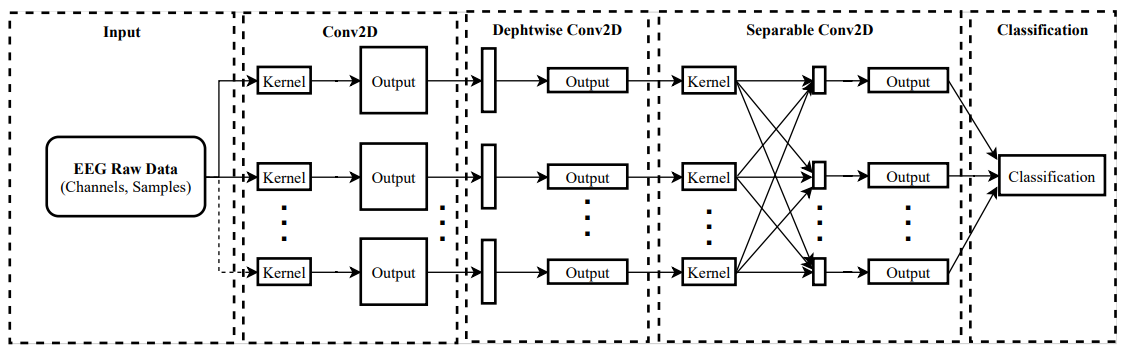

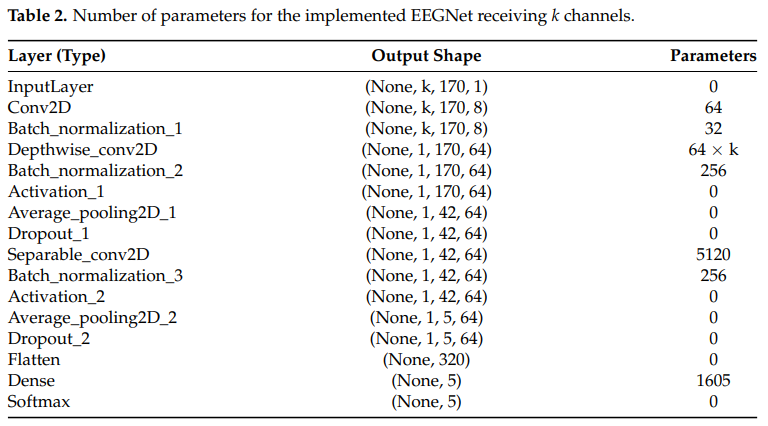

https://doi.org/10.1088/1741-2552/aace8c

-------------------------

### Implement the EEG-Net architecture with only three layers, excluding the spatial information processing layer. Remove the layer associated with the spatial information of electrodes.

## hyperparameters

Define the hyperparameters of the model.

In [14]:
num_class= 3
num_input= 1
channel= 22
signal_length= 200
fs= 200

F1= 8
D= 3
F2= D*F1

kernel_size_1= (1,round(fs/2)) 
kernel_size_2= (channel, 1)
kernel_size_3= (1, round(fs/8))
kernel_size_4= (1, 1)

kernel_avgpool_1= (1,4)
kernel_avgpool_2= (1,8)
dropout_rate= 0.2

ks0= int(round((kernel_size_1[0]-1)/2))
ks1= int(round((kernel_size_1[1]-1)/2))
kernel_padding_1= (ks0, ks1-1)
ks0= int(round((kernel_size_3[0]-1)/2))
ks1= int(round((kernel_size_3[1]-1)/2))
kernel_padding_3= (ks0, ks1)

## defining the base class

Define the EEG-Net model class without the spatial processing layer. Ensure the dimensions are adjusted appropriately with the removal of the specified layer.

In [15]:
import torch.nn as nn

class EEGNet(nn.Module): 
    def __init__(self):
        super().__init__()
        # layer 1
        self.conv2d= nn.Conv2d(num_input, F1, kernel_size_1, padding= kernel_padding_1)
        self.Batch_normalization_1= nn.BatchNorm2d(F1)
        # layer 2
#         self.Depthwise_conv2D= nn.Conv2d(F1, D*F1, kernel_size_2, groups= F1)
#         self.Batch_normalization_2= nn.BatchNorm2d(D*F1)
        self.Elu= nn.ELU()
#         self.Average_pooling2D_1= nn.AvgPool2d(kernel_avgpool_1)
        self.Dropout= nn.Dropout2d(dropout_rate)
        # layer 3
        self.Separable_conv2D_depth= nn.Conv2d(F1, D*F1, kernel_size_3, ###
                                               padding= kernel_padding_3, groups= F1) ###
        self.Separable_conv2D_point= nn.Conv2d(D*F1, F2, kernel_size_4)
        self.Batch_normalization_3= nn.BatchNorm2d(F2)
        self.Average_pooling2D_2= nn.AvgPool2d(kernel_avgpool_2)
        # layer 4
        self.Flatten= nn.Flatten()
        self.Dense= nn.Linear(12672, num_class) ###
        self.Softmax= nn.Softmax(dim= 1)
        
        
    def forward(self, x):
        # layer 1
        y= self.Batch_normalization_1(self.conv2d(x))
        # layer 2
#         y= self.Batch_normalization_2(self.Depthwise_conv2D(y))
#         y= self.Elu(y)
#         y= self.Dropout(self.Average_pooling2D_1(y))
        # layer 3
        y= self.Separable_conv2D_depth(y)
        y= self.Batch_normalization_3(self.Separable_conv2D_point(y))
        y= self.Elu(y)
        y= self.Dropout(self.Average_pooling2D_2(y))
        # layer 4
        y= self.Flatten(y)
        y= self.Dense(y)
        y= self.Softmax(y)
        
        return y

Create a model from the EEG-Net class and define the loss function and optimizer as described in the original paper.

In [16]:
import torch.optim as optim

model= EEGNet()
eta= 0.00015
loss_fn= nn.CrossEntropyLoss()
optimizer= optim.NAdam(model.parameters(), lr= eta)

# Train

## one epoch

Define the function for training a single epoch.  

In [17]:
from torchmetrics import Accuracy

def train_one_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    loss_train= AverageMeter()
    acc_train= Accuracy(task= "multiclass", num_classes= num_class)
    
    for i, (inputs, targets) in enumerate(train_loader):
        outputs= model(inputs)
        loss= loss_fn(outputs, targets)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()

        loss_train.update(loss.item())
        acc_train(outputs, targets.int())
        
    return model, loss_train.avg, acc_train.compute().item()

Define the function for validation and testing over one epoch.

In [18]:
from torchmetrics import F1Score

def test_one_epoch(model, test_loader, loss_fn, optimizer):
    model.eval()
    loss_test= AverageMeter()
    acc_test= Accuracy(task= "multiclass", num_classes= num_class)
    f1_test= F1Score(task= "multiclass", num_classes= num_class)

    for i, (inputs, targets) in enumerate(test_loader):
        outputs= model(inputs)
        loss= loss_fn(outputs, targets)
        loss_test.update(loss.item())
        acc_test(outputs, targets.int())
        f1_test(outputs, targets.int())
        
    return model, loss_test.avg, acc_test.compute().item(), f1_test.compute().item()

## utils

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## training

Train the model for an appropriate number of epochs.  
Display the results for Loss, Accuracy, and F1 Score for all three phases: training, validation, and testing.  
Ensure the model neither overfits (more than 10% difference) nor underfits (test accuracy should not be less than 70%).

In [20]:
num_epochs= 10

loss_train_hist, acc_train_hist= [], []
loss_valid_hist, acc_valid_hist= [], []
loss_test_hist, acc_test_hist= [], []


for epoch in range(num_epochs):
    model, loss_train, acc_train= train_one_epoch(model, train_loader, loss_fn, optimizer)
    model, loss_valid, acc_valid, _= test_one_epoch(model, valid_loader, loss_fn, optimizer)
    model, loss_test, acc_test, f1score= test_one_epoch(model, test_loader, loss_fn, optimizer)
  
    loss_train_hist.append(loss_train)
    acc_train_hist.append(acc_train)
    loss_valid_hist.append(loss_valid)
    acc_valid_hist.append(acc_valid)
    loss_test_hist.append(loss_test)
    acc_test_hist.append(acc_test)
    
    if (epoch%5== 0)or True:
        print(f'epoch {epoch}:')
        print(f' Loss= {loss_train:.4}, Accuracy= {int(acc_train*100)}%')
        print(f' Loss= {loss_valid:.4}, Accuracy= {int(acc_valid*100)}%')
        print(f' Loss= {loss_test:.4}, Accuracy= {int(acc_test*100)}%')
        print(f' f1 score= {(f1score*100):.4}\n')

epoch 0:
 Loss= 1.086, Accuracy= 33%
 Loss= 1.076, Accuracy= 51%
 Loss= 1.07, Accuracy= 50%
 f1 score= 50.83

epoch 1:
 Loss= 1.041, Accuracy= 62%
 Loss= 1.061, Accuracy= 61%
 Loss= 1.051, Accuracy= 64%
 f1 score= 65.0

epoch 2:
 Loss= 0.9948, Accuracy= 72%
 Loss= 1.041, Accuracy= 61%
 Loss= 1.032, Accuracy= 72%
 f1 score= 72.5

epoch 3:
 Loss= 0.9628, Accuracy= 79%
 Loss= 1.02, Accuracy= 66%
 Loss= 1.01, Accuracy= 70%
 f1 score= 70.83

epoch 4:
 Loss= 0.9474, Accuracy= 79%
 Loss= 0.9977, Accuracy= 78%
 Loss= 0.9878, Accuracy= 78%
 f1 score= 78.33

epoch 5:
 Loss= 0.8922, Accuracy= 84%
 Loss= 0.9721, Accuracy= 80%
 Loss= 0.9611, Accuracy= 79%
 f1 score= 79.17

epoch 6:
 Loss= 0.8696, Accuracy= 84%
 Loss= 0.9491, Accuracy= 80%
 Loss= 0.937, Accuracy= 83%
 f1 score= 83.33

epoch 7:
 Loss= 0.8233, Accuracy= 88%
 Loss= 0.9214, Accuracy= 83%
 Loss= 0.9099, Accuracy= 83%
 f1 score= 83.33

epoch 8:
 Loss= 0.7909, Accuracy= 89%
 Loss= 0.8947, Accuracy= 87%
 Loss= 0.8845, Accuracy= 85%
 f1 scor

# Learning Curve

Plot the learning curve of Accuracy for training, validation, and testing phases.

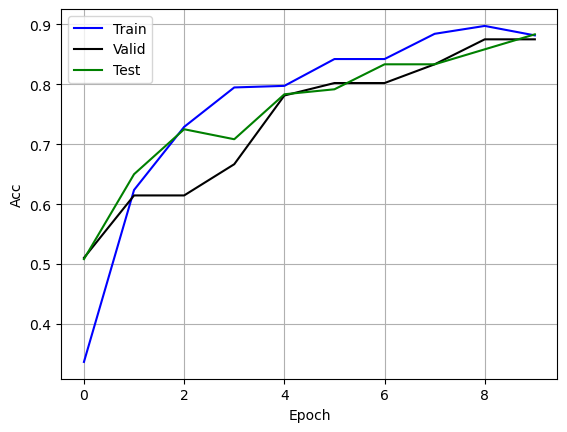

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(len(acc_train_hist)), acc_train_hist, 'b-', label= 'Train')
plt.plot(range(len(acc_valid_hist)), acc_valid_hist, 'k-', label= 'Valid')
plt.plot(range(len(acc_test_hist)), acc_test_hist, 'g-', label= 'Test')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()